# Classification performance assessment

Rainey Aberle

2022/2023

In [ ]:
# -----Import packages
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import scipy
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sys
import pickle
from joblib import dump, load
import json
import datetime

In [ ]:
# -----Define paths in directory
# site_names = ['Emmons', 'LemonCreek']
# base directory (path to snow-cover-mapping/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to classified points used to train and test classifiers
data_pts_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/'
# full path and file name to AOI shapefile
aoi_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission/' 
AOI_fns = [os.path.join(aoi_path, 'LemonCreek', 'AOIs', 'LemonCreek_Glacier_Boundaries_20211005.shp'),
           '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/Emmons/AOIs/Emmons_RGI_outline.shp']
# full path and file name to DEM
DEM_fns = ['/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/DEMs/lemonCreek/LemonCreek_2021.10.05_DEM.tif',
           '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/Emmons/DEMs/Emmons_NASADEM_clip.tif']

# -----Determine settings
terrain_parameters = False # whether to use terrain parameters (elevation, slope, aspect) in classification
save_figures = True # whether to save output figures

# -----Add path to functions
sys.path.insert(1, base_path + 'functions/')
import pipeline_utils as f
import PlanetScope_preprocessing as ps

# -----Load dataset characteristics dictionary
dataset_dict = json.load(open(base_path + 'inputs-outputs/datasets_characteristics.json'))

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = sorted(glob.glob('LemonCreek*.shp') + glob.glob('Emmons*.shp'))
data_pts_fns

Optimal UTM CRS = EPSG:32608


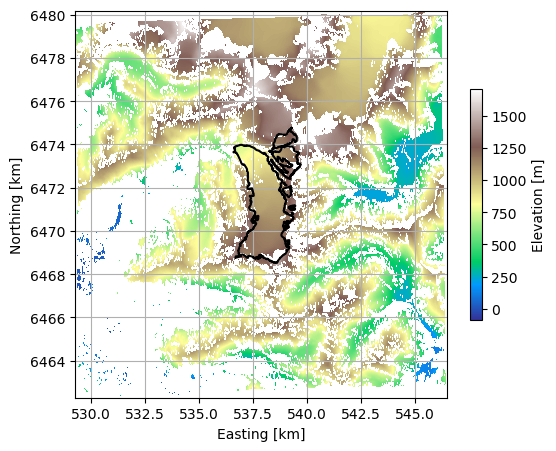

Optimal UTM CRS = EPSG:32610


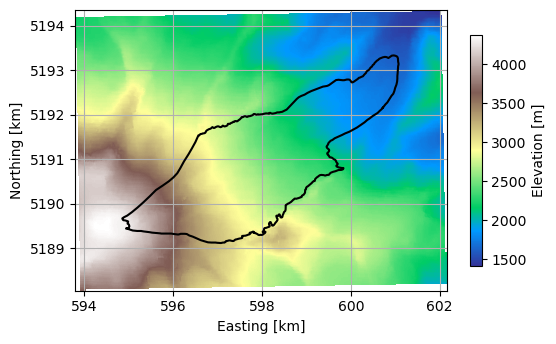

In [40]:
def load_AOI_DEM(AOI_fn, DEM_fn):
    # -----Load AOI as gpd.GeoDataFrame
    AOI = gpd.read_file(AOI_fn)
    # reproject the AOI to WGS to solve for the optimal UTM zone
    AOI_WGS = AOI.to_crs('EPSG:4326')
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                        AOI_WGS.geometry[0].centroid.xy[1][0]]
    # grab the optimal UTM zone EPSG code
    epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
    print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))
    # -----Load DEM as Xarray DataSet
    # reproject AOI to UTM
    AOI_UTM = AOI.to_crs('EPSG:'+str(epsg_UTM))
    # load DEM as xarray DataSet
    DEM = xr.open_dataset(DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject('EPSG:'+str(epsg_UTM))
    DEM = DEM.rio.write_crs('EPSG:'+str(epsg_UTM))
    # remove unnecessary data (possible extra bands from ArcticDEM or other DEM)
    if len(np.shape(DEM.elevation.data))>2:
        DEM['elevation'] = DEM.elevation[0]
    # -----Plot
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    dem_im = ax.imshow(DEM.elevation.data, cmap='terrain', 
              extent=(np.min(DEM.x.data)/1e3, np.max(DEM.x.data)/1e3, np.min(DEM.y.data)/1e3, np.max(DEM.y.data)/1e3))
    if type(AOI_UTM.geometry[0])==Polygon:
        ax.plot([x/1e3 for x in AOI_UTM.geometry[0].exterior.coords.xy[0]],
                [y/1e3 for y in AOI_UTM.geometry[0].exterior.coords.xy[1]], '-k')
    elif type(AOI_UTM.geometry[0])==MultiPolygon:
        [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
                [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in AOI_UTM.geometry[0].geoms]
    ax.grid()
    ax.set_xlabel('Easting [km]')
    ax.set_ylabel('Northing [km]')
    fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m]')
    plt.show()
    return AOI_UTM, DEM, epsg_UTM

AOIs, DEMs, epsg_UTMs = [], [], []
for AOI_fn, DEM_fn in list(zip(AOI_fns, DEM_fns)):
    AOI, DEM, epsg_UTM = load_AOI_DEM(AOI_fn, DEM_fn)
    AOIs.append(AOI)
    DEMs.append(DEM)
    epsg_UTMs.append(epsg_UTM)

## Loop through datasets, load images and classified points, calculate performance metrics, save to file

Landsat
----------
Emmons 20191024
Emmons_Landsat_20191024_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


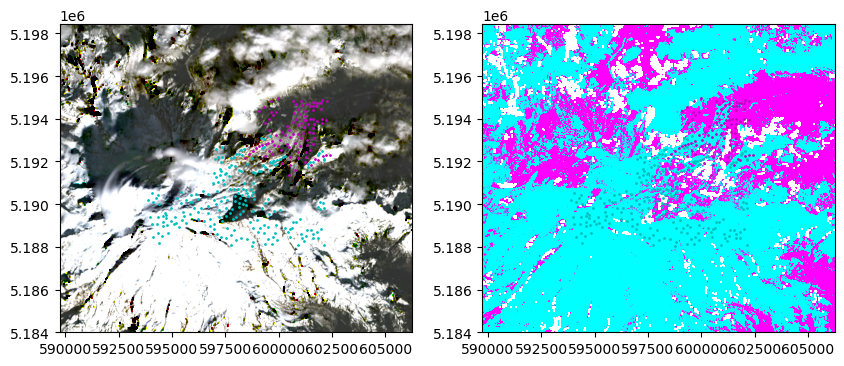

Emmons 20210725
Emmons_Landsat_20210725_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


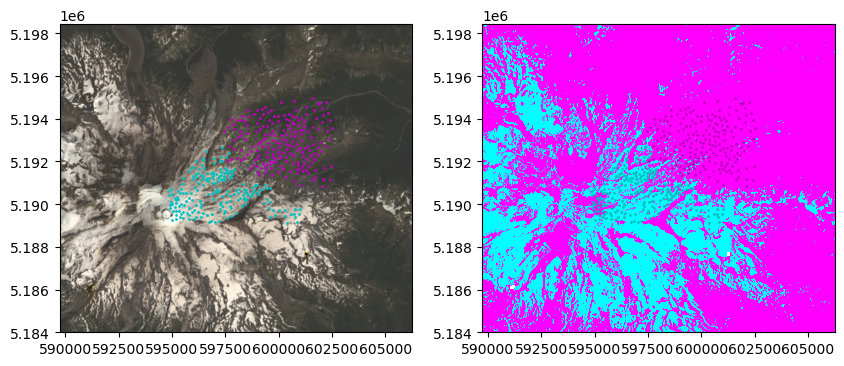

LemonCreek 20210729
LemonCreek_Landsat_20210729_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


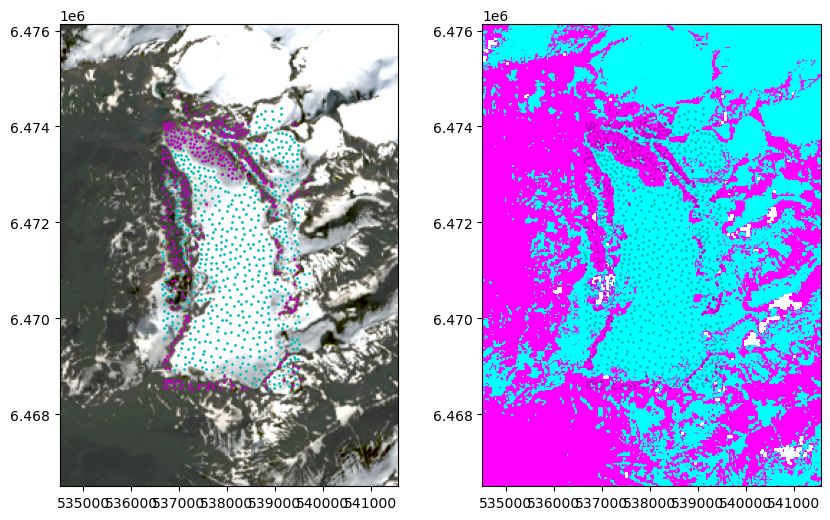

LemonCreek 20210830
LemonCreek_Landsat_20210830_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


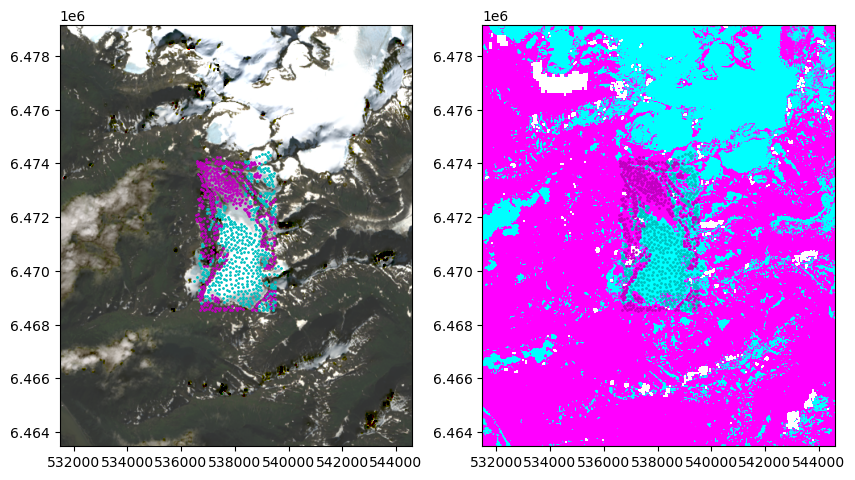

Table of data points saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Landsat_validation_data.csv
PlanetScope
----------
Emmons 20191023
Emmons_PlanetScope_20191023_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


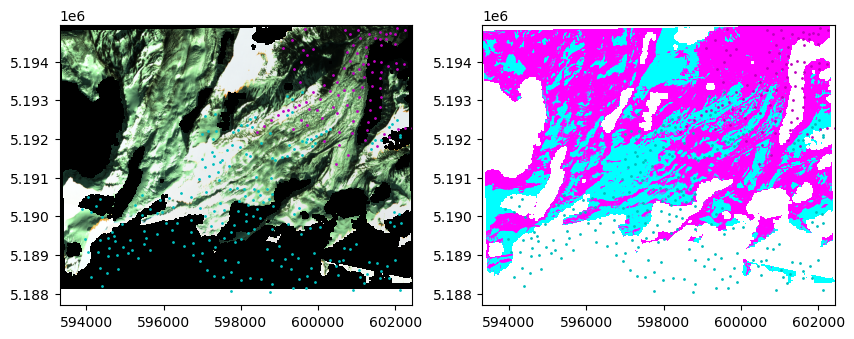

Emmons 20210725
Emmons_PlanetScope_20210725_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


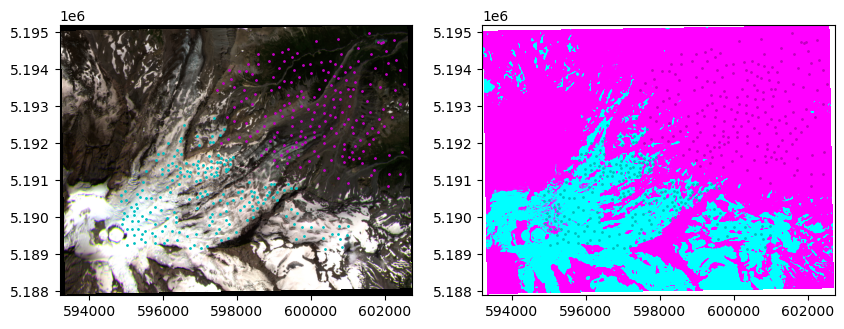

LemonCreek 20210729
LemonCreek_PlanetScope_20210729_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


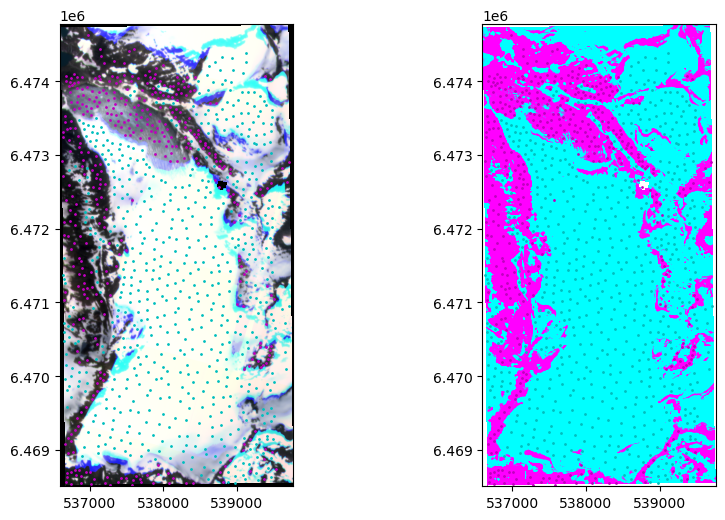

LemonCreek 20210822
LemonCreek_PlanetScope_20210822_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


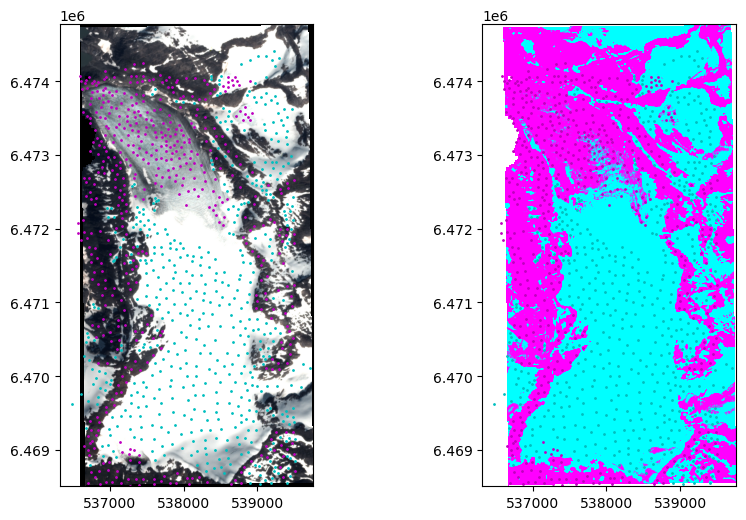

Table of data points saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/PlanetScope_validation_data.csv
Sentinel-2_SR
----------
Emmons 20191030
Emmons_Sentinel-2_SR_20191030_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


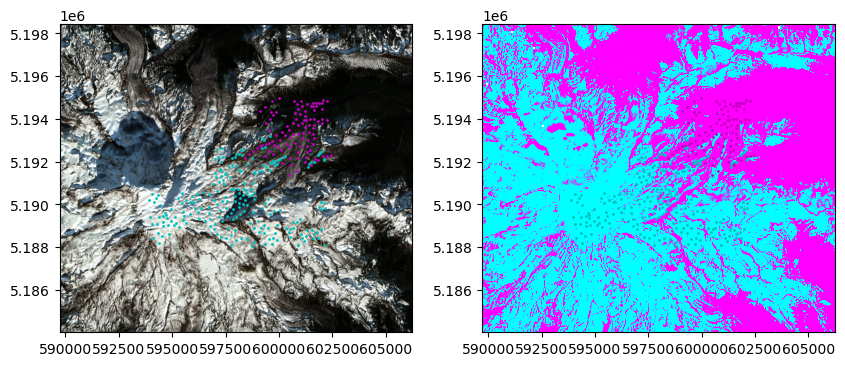

Emmons 20210726
Emmons_Sentinel-2_SR_20210726_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


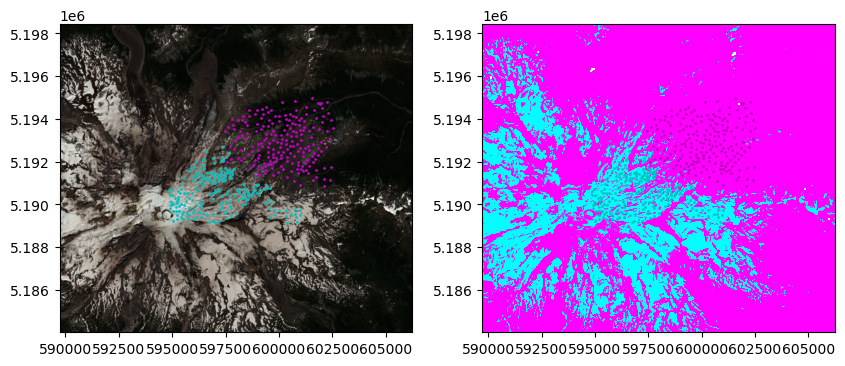

LemonCreek 20210730
LemonCreek_Sentinel-2_SR_20210730_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


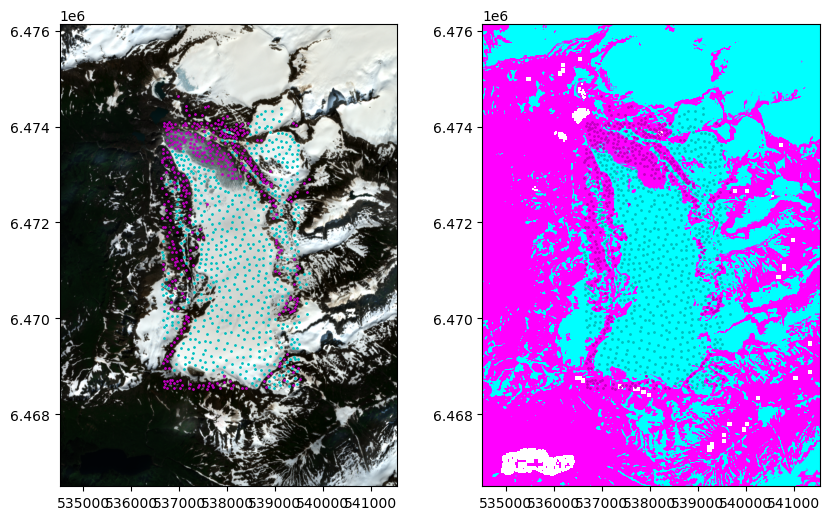

LemonCreek 20210831
LemonCreek_Sentinel-2_SR_20210831_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


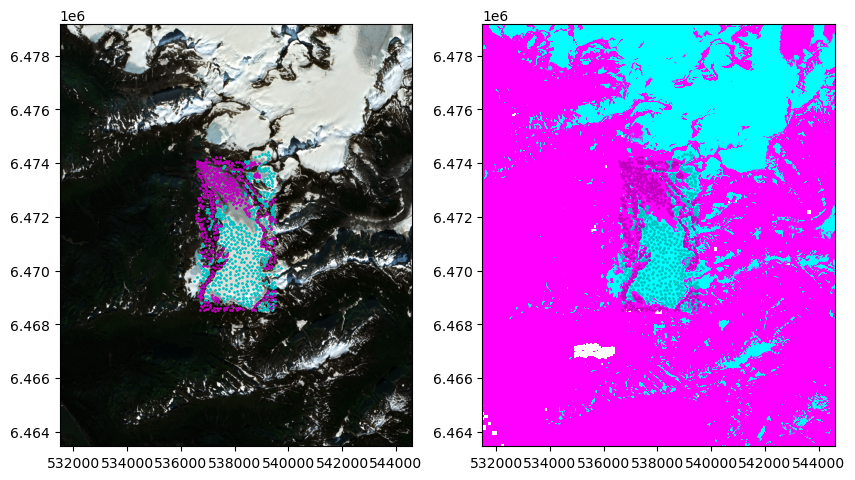

Table of data points saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Sentinel-2_SR_validation_data.csv
Sentinel-2_TOA
----------
Emmons 20191030
Emmons_Sentinel-2_TOA_20191030_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20191030_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


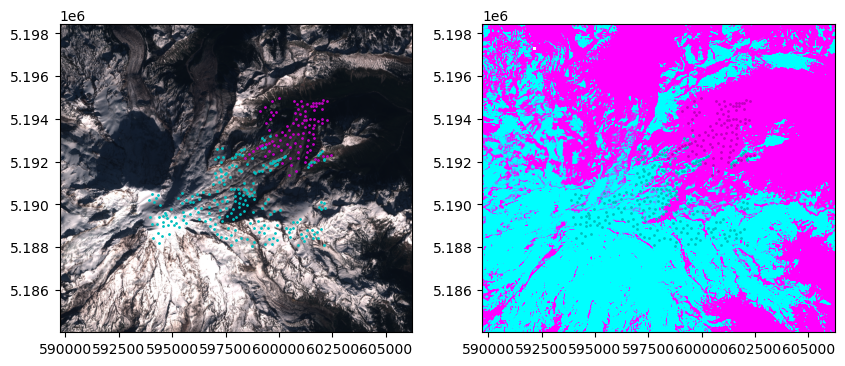

Emmons 20210726
Emmons_Sentinel-2_TOA_20210726_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/Emmons_20210725_no-snow.shp


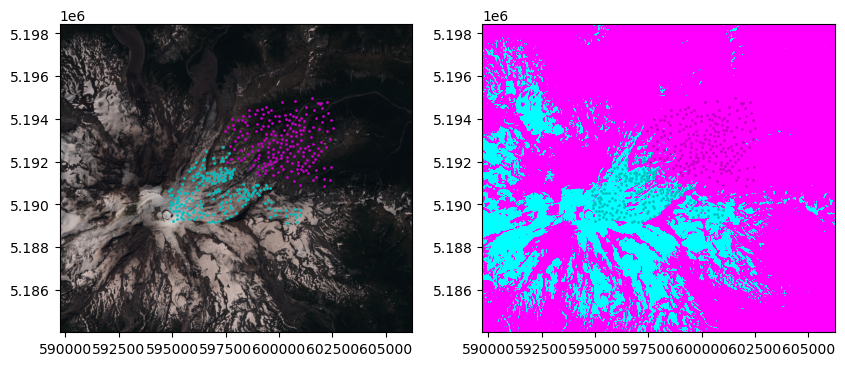

LemonCreek 20210730
LemonCreek_Sentinel-2_TOA_20210730_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210729_20_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


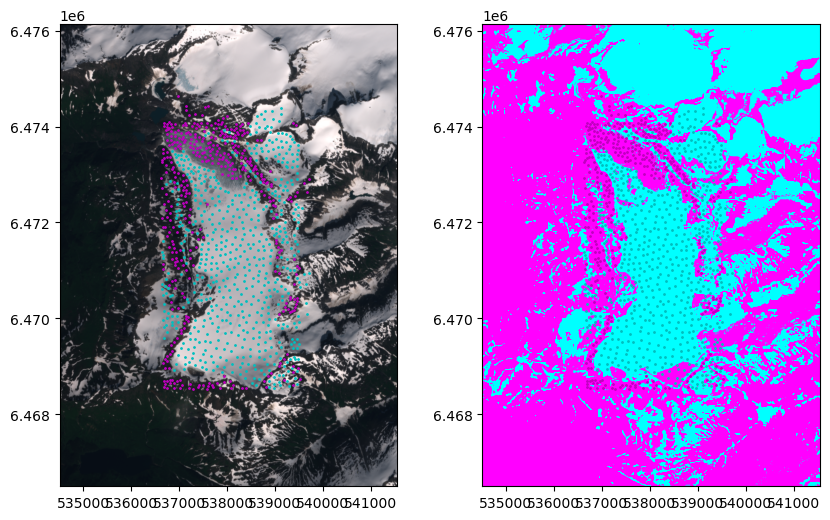

LemonCreek 20210831
LemonCreek_Sentinel-2_TOA_20210831_classified.nc
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_snow.shp
/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/assessment/LemonCreek_20210822_19_no-snow.shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


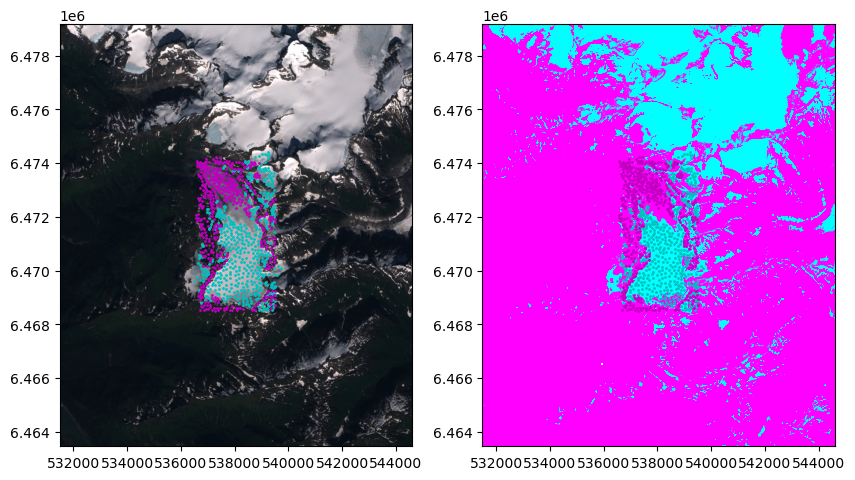

Table of data points saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/Sentinel-2_TOA_validation_data.csv


In [46]:
# -----Define datasets
datasets = ['Landsat', 'PlanetScope', 'Sentinel-2_SR', 'Sentinel-2_TOA']
# load data point file names
data_pts_snow_fns = sorted(glob.glob(data_pts_path+'*_snow.shp'))
data_pts_no_snow_fns = sorted(glob.glob(data_pts_path+'*_no-snow.shp'))
    
# -----Loop through datasets
results_df_full = pd.DataFrame()
for dataset in datasets:
    
    print(dataset)
    print('----------')

    # -----Load trained classifier and feature columns
    clf_fn = os.path.join(base_path, 'inputs-outputs', dataset + '_classifier_all_sites.joblib')
    clf = load(clf_fn)
    feature_cols_fn = os.path.join(base_path, 'inputs-outputs', dataset + '_feature_columns.json')
    feature_cols = json.load(open(feature_cols_fn))

    # -----Check if validation data already exist in file
    data_pts_full_fn = os.path.join(base_path, 'inputs-outputs', dataset + '_manually_classified_points.csv')
    if os.path.exists(data_pts_full_fn):
        print('Validation data already exist in file, loading...')
        data_pts_full = pd.read_csv(data_pts_full_fn)
    else:
    
        # -----Subset dataset dictionary
        ds_dict = dataset_dict[dataset]
    
        # -----Set up testing data
        # load image file names
        im_fns = sorted(glob.glob(os.path.join(data_pts_path, 'LemonCreek_'+dataset+'*.tif')) 
                        + glob.glob(os.path.join(data_pts_path, 'Emmons_'+dataset+'*.tif')))
        # grab dates from image file names
        im_dates = [im_fn[-12:-4] for im_fn in im_fns]
        # initialize full data frame
        data_pts_full = gpd.GeoDataFrame()
    
        # loop through images
        for i, im_fn in enumerate(im_fns):
            
            im_date = im_dates[i]
            
            if 'LemonCreek' in im_fn:
                site_name = 'LemonCreek'
            elif 'Emmons' in im_fn:
                site_name = 'Emmons'
    
            if site_name=='LemonCreek':
                AOI_UTM = AOIs[0]
                DEM = DEMs[0]
                epsg_UTM = epsg_UTMs[0]
            elif site_name=='Emmons':
                AOI_UTM = AOIs[1]
                DEM = DEMs[1]
                epsg_UTM = epsg_UTMs[1]
                
            print(site_name, im_date)

            # Load and pre-process image
            if dataset=='PlanetScope':
                im_xr = xr.open_dataset(im_fn)
                # Adjust image radiometry
                polygons_top, polygons_bottom = ps.create_aoi_elev_polys(AOI_UTM, DEM)
                im_ds, im_adj_method = ps.planetscope_adjust_image_radiometry(im_xr, im_dt, polygons_top, polygons_bottom, dataset_dict, skip_clipped=False) 
            else:
                # load image as xarray.DataArray
                im_da = rxr.open_rasterio(im_fn)
                # reproject to optimal UTM zone (if necessary)
                im_da = im_da.rio.reproject('EPSG:' + str(epsg_UTM))
                # convert to xarray.DataSet
                im_ds = im_da.to_dataset('band')
                band_names = list(ds_dict['refl_bands'].keys())
                im_ds = im_ds.rename({i + 1: name for i, name in enumerate(band_names)})
                # account for image scalar and no data values
                im_ds = xr.where(im_ds != ds_dict['no_data_value'],
                                 im_ds / ds_dict['image_scalar'], np.nan)
                # expand dimensions to include time
                im_dt = np.datetime64(datetime.datetime.fromtimestamp(im_da.attrs['system-time_start'] / 1000))
                im_ds = im_ds.expand_dims({'time': [im_dt]})
                # set CRS
                im_ds.rio.write_crs('EPSG:' + str(im_da.rio.crs.to_epsg()), inplace=True)
                
            # add NDSI band to image
            im_ds['NDSI'] = ((im_ds[ds_dict['NDSI_bands'][0]] - im_ds[ds_dict['NDSI_bands'][1]])
                             / (im_ds[ds_dict['NDSI_bands'][0]] + im_ds[ds_dict['NDSI_bands'][1]]))
            # classify image 
            crop_to_aoi = False
            im_classified_fn = site_name + '_' + dataset + '_' + im_date + '_classified.nc'
            out_path = data_pts_path
            if os.path.exists(out_path + im_classified_fn):
                im_classified_xr = xr.open_dataset(out_path + im_classified_fn)
                # remove no data values
                im_classified_xr = xr.where(im_classified_xr==-9999, np.nan, im_classified_xr) 
                # set CRS
                im_classified_xr.rio.write_crs('EPSG:' + str(im_da.rio.crs.to_epsg()), inplace=True)
            else:
                im_classified_xr = f.classify_image(im_ds, clf, feature_cols, crop_to_aoi, AOI_UTM, DEM, 
                                                    dataset_dict, dataset, im_classified_fn, out_path)
    
            print(im_classified_fn)
        
            # load classified points
            # snow
            data_pts_snow_fn = [x for x in data_pts_snow_fns if (im_date[0:6] in x) and (site_name in x)][0]
            print(data_pts_snow_fn)
            data_pts_snow = gpd.read_file(data_pts_snow_fn) # read file
            data_pts_snow['class'] = 1 # determine class ID
            # no-snow
            if len([x for x in data_pts_no_snow_fns if im_date[0:6] in x])>0:
                data_pts_no_snow_fn =[x for x in data_pts_no_snow_fns if (im_date[0:6] in x) and (site_name in x)][0]
                print(data_pts_no_snow_fn)
                data_pts_no_snow = gpd.read_file(data_pts_no_snow_fn) # read file
                data_pts_no_snow['class'] = 0 # determine class ID
                # combine data pts, reproject to image CRS
                data_pts = pd.concat([data_pts_snow, data_pts_no_snow])
            else: 
                data_pts = data_pts_snow
            data_pts = data_pts.to_crs(im_ds.rio.crs)
            # drop any NaN points
            data_pts = data_pts.drop('id', axis=1)
            data_pts = data_pts.dropna()
            # grab x and y sample points
            data_pts_x = [x.geoms[0].coords.xy[0][0] for x in data_pts.geometry]
            data_pts_y = [x.geoms[0].coords.xy[1][0] for x in data_pts.geometry]
            # sample image values at data points
            for band in feature_cols[0:-1]:
                data_pts[band] = [im_ds[band].sel(x=xx, y=yy, method='nearest').data[0] for xx, yy in list(zip(data_pts_x, data_pts_y))]
        
            # plot RGB and classified image with data points overlain
            fig, ax = plt.subplots(1, 2, figsize=(10,6))
            ax[0].imshow(np.dstack([im_ds[ds_dict['RGB_bands'][0]].data[0], 
                                  im_ds[ds_dict['RGB_bands'][1]].data[0], 
                                  im_ds[ds_dict['RGB_bands'][2]].data[0]]),
                         extent=(np.min(im_ds.x.data), np.max(im_ds.x.data),
                                 np.min(im_ds.y.data), np.max(im_ds.y.data)))
            ax[0].plot([x.geoms[0].coords.xy[0] for x in data_pts.loc[data_pts['class'] == 1]['geometry']],
                       [x.geoms[0].coords.xy[1] for x in data_pts.loc[data_pts['class'] == 1]['geometry']], '.c', markersize=2)
            if len([x for x in data_pts_no_snow_fns if im_date[0:6] in x])>0:
                ax[0].plot([x.geoms[0].coords.xy[0] for x in data_pts.loc[data_pts['class'] == 0]['geometry']],
                           [x.geoms[0].coords.xy[1] for x in data_pts.loc[data_pts['class'] == 0]['geometry']], '.m', markersize=2)
            ax[1].imshow(im_classified_xr.classified.data[0], clim=(2,3), cmap='cool',
                         extent=(np.min(im_classified_xr.x.data), np.max(im_classified_xr.x.data),
                                 np.min(im_classified_xr.y.data), np.max(im_classified_xr.y.data)))
            ax[1].plot([x.geoms[0].coords.xy[0] for x in data_pts.loc[data_pts['class'] == 1]['geometry']],
                       [x.geoms[0].coords.xy[1] for x in data_pts.loc[data_pts['class'] == 1]['geometry']], '.c', markersize=2)
            if len([x for x in data_pts_no_snow_fns if im_date[0:6] in x])>0:
                ax[1].plot([x.geoms[0].coords.xy[0] for x in data_pts.loc[data_pts['class'] == 0]['geometry']],
                           [x.geoms[0].coords.xy[1] for x in data_pts.loc[data_pts['class'] == 0]['geometry']], '.m', markersize=2)
            plt.show()

            # add image date, dataset, and site name to dataframe
            data_pts['image_date'] = im_date
            data_pts['image_product'] = dataset
            data_pts['site_name'] = site_name
            
            # reproject to WGS84 for compatibility
            data_pts = data_pts.to_crs('EPSG:4326')
            
            # concatenate to data_pts_full
            data_pts_full = pd.concat([data_pts_full, data_pts])
    
        # Add NDSI column
        data_pts_full['NDSI'] = ((data_pts_full[ds_dict['NDSI_bands'][0]] - data_pts_full[ds_dict['NDSI_bands'][1]]) 
                                  /(data_pts_full[ds_dict['NDSI_bands'][0]] + data_pts_full[ds_dict['NDSI_bands'][1]]) )
        # Reduce memory usage in data pts
        data_pts_full = data_pts_full.dropna().reset_index(drop=True)
        data_pts_full = f.reduce_memory_usage(data_pts_full, verbose=False)
        # Reorder columns
        cols_order = ['site_name', 'image_date', 'image_product', 'class'] + feature_cols + ['geometry']
        data_pts_full = data_pts_full[cols_order]
        # Save to file
        data_pts_full.to_csv(data_pts_full_fn, index=False)
        print('Table of data points saved to file: ' + data_pts_full_fn)

    # # -----Test the trained classifier
    # # features
    # X = data_pts_full[feature_cols] 
    # # target variable
    # y = data_pts_full['class'] 
    # # Predict class values using trained classifier
    # y_pred = clf.predict(X)
    # # Adjust outputs to only test snow and no-snow
    # y_pred[y_pred <= 2] = 1 # snow = 1, 2
    # y_pred[y_pred > 2] = 0 # no-snow = 3, 4, 5
    # # Calculate overall accuracy
    # accuracy = metrics.accuracy_score(y, y_pred)
    # # Calculate Kappa score
    # K = metrics.cohen_kappa_score(y, y_pred)
    # # Calculate recall
    # R = metrics.recall_score(y, y_pred)
    # # Calculate precision
    # P = metrics.precision_score(y, y_pred)
    # # Calculate F1 score
    # F1 = metrics.f1_score(y, y_pred)
    # # Calculate confusion matrix
    # CM = metrics.confusion_matrix(y, y_pred)
    # # print results
    # print('n = '+str(len(y_pred)))
    # print('Overall accuracy = '+str(accuracy))
    # print('Kappa score = '+str(K))
    # print('Recall = '+str(R))
    # print('Precision = '+str(P))
    # print('F1 score = '+str(F1))
    # print('Confusion matrix: ')
    # print(CM)
    # print(' ')
    
    # # -----Add results to dataframe
    # results_df = pd.DataFrame({'Dataset': dataset,
    #                            'Overall accuracy': accuracy,
    #                            'Kappa score': K,
    #                            'Recall': R,
    #                            'Precision': P,
    #                            'F1 score': F1,
    #                            'Confusion matrix': [CM],
    #                            'N': len(y_pred)
    #                           })
    # results_df_full = pd.concat([results_df_full, results_df])

    # print(' ')

# -----Save results to file
# results_fn = base_path + 'inputs-outputs/classification_performace_metrics.csv'
# results_df_full.to_csv(results_fn, index=False)
# print('Performance metrics saved to file: '+results_fn)